## Homework #4: NeuralNet

В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    
    def __init__(self, layers_sizes, normalize = True, learning_rate = 0.01, num_iter = 15000, costs_iters=300, tol=1e-7):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_sizes = layers_sizes
        self.tol = tol
        self.layers = len(layers_sizes) + 1
        print("Layers: {}".format(self.layers))
        self.costs_iters = costs_iters
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, A):
        return np.multiply(A, 1 - A)
    
    def __initialize_parameters(self):
        W, b = [], []
        
        for l in range(1,self.layers+1):
            W_l = np.random.randn(self.layers_sizes[l], self.layers_sizes[l-1]) * 0.01
            b_l = np.zeros((self.layers_sizes[l], 1))
            W.append(W_l)
            b.append(b_l)
        
        self.parameters = {"W" : W, "b" : b}
        
        for key in self.parameters:
            for key_i,i in zip(self.parameters[key],range(len(self.parameters[key]))):
                print("{}{}: {}".format(key,i+1,key_i.shape))
       
    def __forward_propagation(self, X):            
        W = self.parameters["W"]
        b = self.parameters["b"]
        Z, A = [], [] 

        A.append(X)
        for l in range(0,self.layers):
            Z_l = np.dot(W[l],A[l]) + b[l]
            A_l = self.__sigmoid(Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        cache = (Z,A)
        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        (Z,A) = cache
        
        dZ, dW, db = [], [], []
        
        dZ_l = A[-1] - Y
        dW_l = 1. / m * np.dot(dZ_l, A[-2].T)
        db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
        
        dZ.insert(0,dZ_l)
        dW.insert(0,dW_l)
        db.insert(0,db_l)
        
        for l in range(self.layers-1,0,-1):
            dA_l = np.dot(W[l].T,dZ_l)
            dZ_l = np.multiply(dA_l, self.__sigmoid_derivative(A[l]))
            dW_l = 1. / m * np.dot(dZ_l, A[l-1].T)
            db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
            dZ.insert(0,dZ_l)
            dW.insert(0,dW_l)
            db.insert(0,db_l)
        
        grads = {"dZ":dZ,"dW":dW,"db":db}
        return grads
  
    
    def __update_parameters(self, grads):        
        W = self.parameters["W"]
        b = self.parameters["b"]
        dW = grads["dW"]
        db = grads["db"]
    
        for l in range(0,len(W)):
            W[l] = W[l] - self.learning_rate * dW[l]
            b[l] = b[l] - self.learning_rate * db[l]
            
        self.parameters["W"] = W
        self.parameters["b"] = b

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_imp = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.layers_sizes.insert(0,n_x)
        self.layers_sizes.append(1);
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            
            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            
            costs_imp.append(cost)
            if i > self.costs_iters:
                len_imp = len(costs_imp)-1
                if abs(costs_imp[len_imp] - costs_imp[len_imp-self.costs_iters]) < self.tol:
                    print("Stop iteration: {}".format(i))
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100, 1)


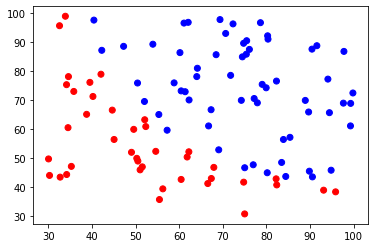

In [6]:
plot_data(X, Y)

In [7]:
cls = NeuralNet(layers_sizes = [5,5], normalize = True, learning_rate = 0.1, num_iter = 12001, tol = 1e-7, costs_iters=500)

Layers: 3


W1: (5, 2)
W2: (5, 5)
W3: (1, 5)
b1: (5, 1)
b2: (5, 1)
b3: (1, 1)
0-th iteration: 0.6940568147289242
1000-th iteration: 0.6730114221769741
2000-th iteration: 0.6730101074963257
3000-th iteration: 0.6730072851524028
4000-th iteration: 0.6730001004781921
5000-th iteration: 0.6729805449328531
6000-th iteration: 0.6729215198880175
7000-th iteration: 0.6726928844858423
8000-th iteration: 0.6709607054869765
9000-th iteration: 0.553802725797257
10000-th iteration: 0.23486153202002227
11000-th iteration: 0.207593452603913
12000-th iteration: 0.15346915121475302


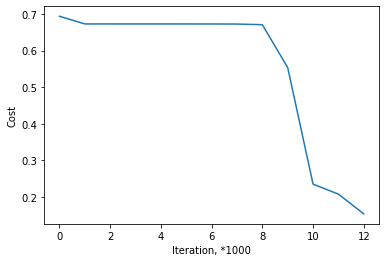

In [8]:
cls.fit(X, Y)

In [9]:
for key in cls.parameters:
    print("{}:\n".format(key))
    for i in cls.parameters[key]:
        print("{}\n".format(i))

W:

[[-1.53169403 -1.40351282]
 [ 0.5388818   2.15145389]
 [-1.07593666 -1.66760792]
 [-0.34788647 -0.3020824 ]
 [-2.84186948 -0.41027941]]

[[-1.24948319  1.52929236 -1.13808768 -0.10287222 -1.8763618 ]
 [-1.32298772  1.65744346 -1.18150755 -0.09470886 -2.02351245]
 [-1.22954219  1.46724949 -1.11100345 -0.11979845 -1.81425218]
 [-0.83176335  0.67406121 -0.76873088 -0.20032967 -1.07164987]
 [-1.17488448  1.39826955 -1.06867871 -0.14150683 -1.74631764]]

[[2.79900739 3.08860333 2.68029636 1.13731165 2.51526831]]

b:

[[-0.81915427]
 [ 1.37561208]
 [-0.79418765]
 [-0.03493189]
 [-2.18170321]]

[[ 0.4393794 ]
 [ 0.52538609]
 [ 0.41346118]
 [-0.04818405]
 [ 0.36039529]]

[[-4.71629928]]



In [10]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.09832981, 0.90167019],
       [0.01271196, 0.98728804],
       [0.0610259 , 0.9389741 ],
       [0.99089722, 0.00910278],
       [0.99448441, 0.00551559],
       [0.02750094, 0.97249906],
       [0.99429105, 0.00570895],
       [0.47056224, 0.52943776],
       [0.99574053, 0.00425947],
       [0.64779512, 0.35220488],
       [0.71393941, 0.28606059],
       [0.07124647, 0.92875353],
       [0.99512878, 0.00487122],
       [0.99582191, 0.00417809],
       [0.150635  , 0.849365  ],
       [0.98294947, 0.01705053],
       [0.5979301 , 0.4020699 ],
       [0.21359586, 0.78640414],
       [0.99566875, 0.00433125],
       [0.61611257, 0.38388743],
       [0.11288689, 0.88711311],
       [0.99353064, 0.00646936],
       [0.02583436, 0.97416564],
       [0.01308697, 0.98691303],
       [0.99158853, 0.00841147],
       [0.96124587, 0.03875413],
       [0.57105698, 0.42894302],
       [0.66569213, 0.33430787],
       [0.1499804 , 0.8500196 ],
       [0.03461285, 0.96538715],
       [0.

In [11]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [12]:
accuracy_score(Y, Y_hat)

0.94

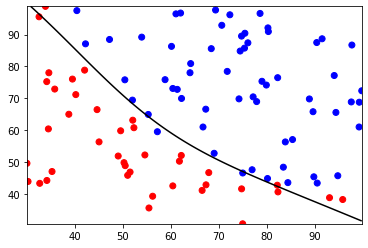

In [13]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [14]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X2, Y2 = df[data_columns].values, df[target_column].values.reshape((df.shape[0], 1))
print('Training set: X={}, y={}'.format(X2.shape, Y2.shape))

Training set: X=(118, 2), y=(118, 1)


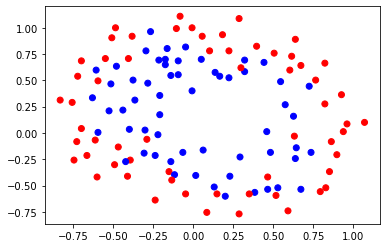

In [15]:
plot_data(X2, Y2)

In [16]:
cls2 = NeuralNet(layers_sizes = [70,60], normalize = True, learning_rate = 0.5, num_iter = 20001, tol = 1e-7, costs_iters=500)

Layers: 3


W1: (70, 2)
W2: (60, 70)
W3: (1, 60)
b1: (70, 1)
b2: (60, 1)
b3: (1, 1)
0-th iteration: 0.6931122637599516
1000-th iteration: 0.6930030324419183
2000-th iteration: 0.6930025964252035
3000-th iteration: 0.6930019920016677
4000-th iteration: 0.6930010781192227
5000-th iteration: 0.6929995841408956
6000-th iteration: 0.6929969311138324
7000-th iteration: 0.6929917141355143
8000-th iteration: 0.6929799111961886
9000-th iteration: 0.6929469412695829
10000-th iteration: 0.69281675235803
11000-th iteration: 0.691976394992391
12000-th iteration: 0.6898457590193997
13000-th iteration: 0.6869874302880266
14000-th iteration: 0.6167177738510543
15000-th iteration: 0.5674632718938167
16000-th iteration: 0.5499750048668358
17000-th iteration: 0.54253185684083
18000-th iteration: 0.540862509289764
19000-th iteration: 0.5393341791097561
20000-th iteration: 0.5318318308404386


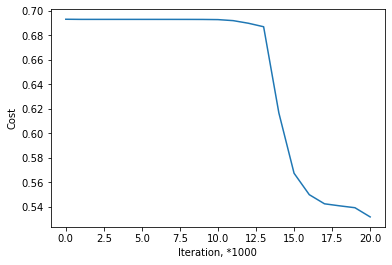

In [17]:
cls2.fit(X2, Y2)

In [18]:
for key in cls2.parameters:
    print("{}:\n".format(key))
    for i in cls2.parameters[key]:
        print("{}\n".format(i))

W:

[[-0.6438998  -0.81577722]
 [ 0.92356949  0.75778866]
 [-0.66815747 -0.8199582 ]
 [ 0.34247337  0.34967714]
 [-0.64289351 -0.80705442]
 [-0.28520669  0.58915574]
 [-0.58863749 -0.75729875]
 [ 0.47973022  0.48975137]
 [ 0.06548763  0.10722553]
 [ 0.23512573  0.16818748]
 [ 0.09298977 -0.50973607]
 [ 0.08441972 -0.52558354]
 [ 0.15844266 -0.49892544]
 [-0.66134461 -0.8313209 ]
 [ 0.06766661 -0.59462983]
 [ 0.95317511  0.82275688]
 [-0.84124706 -1.0667448 ]
 [ 0.44153186  0.51496903]
 [ 0.27431343 -0.34145043]
 [ 0.9285554   0.76186012]
 [ 0.41184089  0.52631252]
 [ 0.27630772 -0.37989082]
 [-0.05446847 -0.6370235 ]
 [ 0.95566189  0.79729816]
 [-0.0330364  -0.61804365]
 [-0.57072244 -0.77080577]
 [ 0.94345692  0.78661522]
 [-0.64613693 -0.82121553]
 [-0.69118023 -0.88118796]
 [ 0.66107451  0.59239853]
 [ 0.34764534  0.50402231]
 [ 0.40825073  0.42576655]
 [-0.72261149 -0.92543937]
 [-0.51070523 -0.7448247 ]
 [ 0.78271019  0.62255292]
 [ 0.11711325 -0.61120273]
 [-0.05017686  0.6078092

In [19]:
Y2_prob = cls2.predict_proba(X2)
Y2_prob

array([[0.62010077, 0.37989923],
       [0.53913989, 0.46086011],
       [0.64177008, 0.35822992],
       [0.36506025, 0.63493975],
       [0.03048491, 0.96951509],
       [0.7392596 , 0.2607404 ],
       [0.02319579, 0.97680421],
       [0.52200026, 0.47799974],
       [0.62376524, 0.37623476],
       [0.76139352, 0.23860648],
       [0.67443357, 0.32556643],
       [0.16005105, 0.83994895],
       [0.19593629, 0.80406371],
       [0.25300503, 0.74699497],
       [0.65715764, 0.34284236],
       [0.66206859, 0.33793141],
       [0.77661227, 0.22338773],
       [0.58315865, 0.41684135],
       [0.6740854 , 0.3259146 ],
       [0.45736402, 0.54263598],
       [0.72366498, 0.27633502],
       [0.73770385, 0.26229615],
       [0.76904903, 0.23095097],
       [0.1804578 , 0.8195422 ],
       [0.72690666, 0.27309334],
       [0.70657802, 0.29342198],
       [0.14254008, 0.85745992],
       [0.74144104, 0.25855896],
       [0.589614  , 0.410386  ],
       [0.70518282, 0.29481718],
       [0.

In [20]:
Y2_hat = cls2.predict(X2)
Y2_hat

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1])

In [21]:
accuracy_score(Y2, Y2_hat)

0.7203389830508474

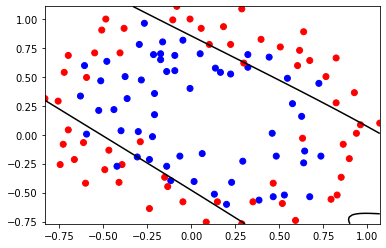

In [22]:
plot_data(X2, Y2)
plot_surface(cls2, X2[:, 0], X2[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [23]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,20), max_iter = 20001, solver = 'adam', activation = 'relu')#, solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [24]:
clf.fit(X2, Y2)

D:\ProgFiles\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=20001)

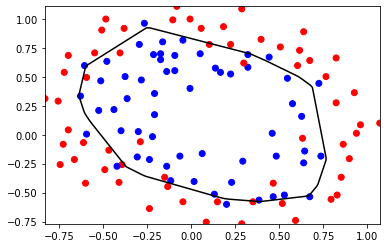

In [25]:
plot_data(X2, Y2)
plot_surface(clf, X2[:, 0], X2[:, 1])

In [26]:
accuracy_score(Y2, clf.predict(X2))

0.864406779661017

In [27]:
clf.n_iter_

465